<a href="https://colab.research.google.com/github/catarina-moreira/causabilityXAi/blob/master/Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demystifying Predictive Black-Box Models: An Interpretable Probabilistic Approach

Catarina Moreira, Yu-Liang Chou, Mythreyi Velmurugan, Renuka Sindhgatta Rajan, Chun Ouyang, Peter Bruza

**Abstract** 


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# login into my google drive account
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

learning_lib = drive.CreateFile( {'id' : '1wwSN3AIl_dmayKENu5jnc1BRaNPe8BZc'}).GetContentFile("learning.py")


In [3]:
# Install tensorflow
try:
    # tensorflow_version only exists in Colab
    %tensorflow_version 2.x
except Exception:
    pass

In [ ]:
# library to deal with Bayesian Networks
!pip install pyagrum
!pip install lime
!pip install shap

In [9]:
# for reproduciability reasons:
import numpy as np
import pandas as pd
import random as rn
import time

%matplotlib inline

# import auxiliary functions
from learning import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Breast Cancer Wisconsin (Diagnostic) Data Set

**Context**
Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. Described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].


Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

**Content**
Attribute Information:

1) ID number
2) Diagnosis (1 = malignant, 0 = benign)

3-32)
Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)
b) texture (standard deviation of gray-scale values)
c) perimeter
d) area
e) smoothness (local variation in radius lengths)
f) compactness (perimeter^2 / area - 1.0)
g) concavity (severity of concave portions of the contour)
h) concave points (number of concave portions of the contour)
i) symmetry
j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant


### Checking Dataset

In [10]:
# path to project folder
# please change to your own
PATH = "/content/drive/My Drive/Colab Notebooks/DDS/"

In [11]:
# name of dataset
DATASET_NAME = "breast_cancer.csv"

# variable containing the class labels in this case the dataset contains:
# 0 - if not diabetes
# 1 - if diabetes
class_var = "diagnosis"

# load dataset
dataset_path = PATH + "datasets/" + DATASET_NAME
data = pd.read_csv( dataset_path ).drop(["id", "Unnamed: 32"], axis=1)


In [12]:
# features
feature_names = data.drop([class_var], axis=1).columns.to_list()

# check how balanced the classes are
data.groupby(class_var).count()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,357,357,357,357,357,357,357,357,357,357,357,357,357,357,357,357,357,357,357,357,357,357,357,357,357,357,357,357,357,357
1,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212


### Balanced Dataset

In [13]:
# balance dataset
sampled_data = data.sample(frac=1)
sampled_data = sampled_data[ sampled_data[class_var] == 0]
B_data = sampled_data.sample(frac=1)[0:212]

M_data = data[ data[class_var] == 1]

balanced_data = [B_data,M_data]
balanced_data = pd.concat(balanced_data)

# check how balanced the classes are
balanced_data.groupby(class_var).count()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212
1,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212


#### Train a Model for the Balanced Dataset

In [14]:
# apply one hot encoder to data
# standardize the input between 0 and 1
X, Y, encoder, scaler = encode_data( balanced_data, class_var)

n_features = X.shape[1]
n_classes = len(balanced_data[class_var].unique())
 
flag = False  # DO NOT CHANGE! Data has already been generated. 
if flag:
    # save training, test and validation data
    generate_save_training_data( dataset_path, X, Y)
    
    # load data
    X_train, Y_train, X_test, Y_test, X_validation, Y_validation= load_training_data( dataset_path )
    
else:
    # load existing training data
    X_train, Y_train, X_test, Y_test, X_validation, Y_validation= load_training_data( dataset_path )
    

In [15]:
# generate models for grid search
if flag:
    models = grid_search_model_generator( n_features, n_classes )

    # perform grid_search
    HISTORY_DICT = perform_grid_search( models, PATH, DATASET_NAME.replace(".csv",""), 
                                   X_train, Y_train, 
                                   X_validation, Y_validation, X_test, Y_test, 
                                   batch_size=8, epochs=150 )

In [16]:
path_serialisation_model = PATH + "training/" + DATASET_NAME.replace(".csv", "") + "/model/" 
path_serialisation_histr = PATH + "training/" + DATASET_NAME.replace(".csv", "") + "/history/" 

# the best performing model was obtained with 5 hidden layers with 12 neurons each
model_name = "model_h4_N12"
    
if flag:
    
    # get respective model training history and model
    model_history = HISTORY_DICT[ model_name ][0]
    model = HISTORY_DICT[ model_name ][1]

    # save model and model history to file
    save_model_history(  model_history, model_name, path_serialisation_histr )
    save_model( model, model_name, path_serialisation_model )
    
    # load data
    model_history = load_model_history( model_name, path_serialisation_histr )
    model = load_model( model_name, path_serialisation_model )
else:
    model_history = load_model_history( model_name, path_serialisation_histr )
    model = load_model( model_name, path_serialisation_model )
    
model.summary()

Loaded model from disk
Model: "model_h4_N12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_887 (Dense)            (None, 12)                372       
_________________________________________________________________
dense_888 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_889 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_890 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_891 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_892 (Dense)            (None, 2)                 26        
Total params: 1,022
Trainable params: 1,022
Non-trainable params: 0
_____________________________

#### Evaluate Model

In [17]:
# evaluate loaded model on test and training data
optim = keras.optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=1)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=1)

print('\n[Accuracy] Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('[Loss] Train: %.3f, Test: %.3f' % (train_loss, test_loss))

2/2 [==============================] - 0s 6ms/step - loss: 0.0790 - accuracy: 0.9841

[Accuracy] Train: 0.966, Test: 0.984
[Loss] Train: 0.092, Test: 0.079


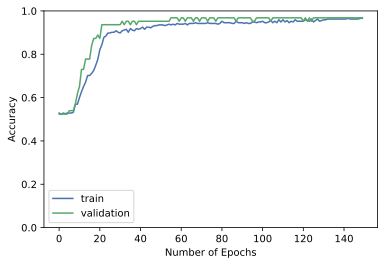

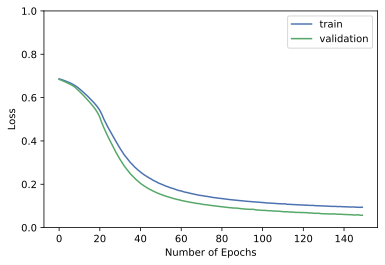

In [18]:
%matplotlib inline
plot_model_history( model_history, 'Accuracy' )
plot_model_history( model_history, 'Loss' )


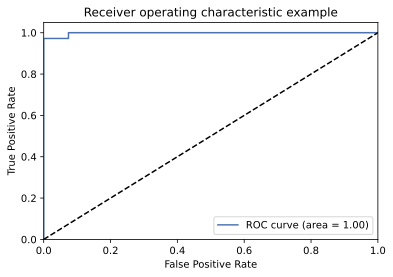

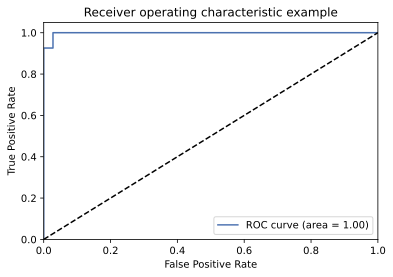

In [19]:
# plot ROC curve
plot_ROC_Curve( model, X_test, Y_test, n_classes)

